# Purpose:
- Calculate threshold for merging or leaving.
- First, look at the distribution of IoA when IoU <= 0.3
- Also, look at what diameter it stops to gather a new ROI.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
mice = [25,27,30,36,39,52]
test_sessions = [1,15]
planes = range(1,9)
save_dir = Path(r'C:\Users\shires\Dropbox\Works\Projects\2020 Neural stretching in S1\Analysis\cellpose_mask_test')
base_dir_1 = Path('F:/')
base_dir_2 = Path('D:/')

In [75]:
a = []
b = np.array([0,1])
a.extend(b)
a

[0, 1]

In [78]:
def get_overlap_mat(mask1, mask2):
    roi_inds1 = np.setdiff1d(np.unique(mask1), [0])
    roi_inds2 = np.setdiff1d(np.unique(mask2), [0])
    overlap_mat = np.zeros((len(roi_inds1), len(roi_inds2)))
    visited_roi_inds2 = []
    for j in range(len(roi_inds1)):
        temp_roi_ind1_map = mask1 == roi_inds1[j]
        temp_roi_ind2_visit = np.setdiff1d(np.unique(mask2[temp_roi_ind1_map]), [0])
        visited_roi_inds2.extend(temp_roi_ind2_visit)
        for temp_roi_2 in temp_roi_ind2_visit:
            k = np.where(roi_inds2 == temp_roi_2)[0][0]
            intersection_map = temp_roi_ind1_map * (mask2 == temp_roi_2) > 0
            union_map = temp_roi_ind1_map + (mask2 == temp_roi_2) > 0
            overlap_mat[j, k] = np.sum(intersection_map) / np.sum(union_map)
    left_roi_inds2 = np.setdiff1d(roi_inds2, np.unique(visited_roi_inds2))
    for temp_roi_ind2 in left_roi_inds2:
        k = np.where(roi_inds2 == temp_roi_2)[0][0]
        temp_roi_ind2_map = mask2 == temp_roi_ind2
        temp_roi_ind1_visit = np.setdiff1d(np.unique(mask1[temp_roi_ind2_map]), [0])
        for temp_roi_ind1 in temp_roi_ind1_visit:
            j = np.where(roi_inds1 == temp_roi_ind1)[0][0]
            intersection_map = temp_roi_ind2_map * (mask1 == temp_roi_ind1) > 0
            union_map = temp_roi_ind2_map + (mask1 == temp_roi_ind1) > 0
            overlap_mat[j, k] = np.sum(intersection_map) / np.sum(union_map)
    return overlap_mat

def get_overlap_mat_list(masks):
    overlap_mat_list = []
    for i in range(masks.shape[0]-1):
        temp_overlap_mat = get_overlap_mat(masks[i, :, :], masks[i+1, :, :])
        overlap_mat_list.append(temp_overlap_mat)
    return overlap_mat_list

def draw_mask_overlaps(ax, mask_curr, mask_next, roi_ind_curr, roi_ind_next, buffer=10):
    img_dims = mask_curr.shape
    assert img_dims == mask_next.shape
    yrange = [img_dims[0], 0]
    xrange = [img_dims[1], 0]

    if isinstance(roi_ind_curr, (int, np.integer)):
        roi_ind_curr = [roi_ind_curr]
    if isinstance(roi_ind_next, (int, np.integer)):
        roi_ind_next = [roi_ind_next]
    
    curr_roi_nums = np.setdiff1d(np.unique(mask_curr), [0])
    next_roi_nums = np.setdiff1d(np.unique(mask_next), [0])

    temp_curr_mask = np.zeros(img_dims, dtype=bool)
    for i in roi_ind_curr:
        roi_num = curr_roi_nums[i]
        draw_curr_mask = np.zeros(img_dims, dtype=bool)
        temp_curr_mask[mask_curr == roi_num] = True
        draw_curr_mask[mask_curr == roi_num] = True
        draw_contours(ax, draw_curr_mask, colors='m', linewidths=1)
        temp_inds = np.where(mask_curr == roi_num)
        yrange[0] = min(np.min(temp_inds[0]), yrange[0])
        yrange[1] = max(np.max(temp_inds[0]), yrange[1])
        xrange[0] = min(np.min(temp_inds[1]), xrange[0])
        xrange[1] = max(np.max(temp_inds[1]), xrange[1])
    temp_next_mask = np.zeros(img_dims, dtype=bool)
    for i in roi_ind_next:
        roi_num = next_roi_nums[i]
        draw_next_mask = np.zeros(img_dims, dtype=bool)
        temp_next_mask[mask_next == roi_num] = True
        draw_next_mask[mask_next == roi_num] = True
        draw_contours(ax, draw_next_mask, colors='c', linewidths=1)
        temp_inds = np.where(mask_next == roi_num)
        yrange[0] = min(np.min(temp_inds[0]), yrange[0])
        yrange[1] = max(np.max(temp_inds[0]), yrange[1])
        xrange[0] = min(np.min(temp_inds[1]), xrange[0])
        xrange[1] = max(np.max(temp_inds[1]), xrange[1])
    
    yrange[0] = max(yrange[0] - buffer, 0)
    yrange[1] = min(yrange[1] + buffer, img_dims[0])
    xrange[0] = max(xrange[0] - buffer, 0)
    xrange[1] = min(xrange[1] + buffer, img_dims[1])
    ax.set_xlim(xrange)
    ax.set_ylim(yrange)

    intersection = np.logical_and(temp_curr_mask, temp_next_mask)
    ioa_curr = intersection.sum() / temp_curr_mask.sum()
    ioa_next = intersection.sum() / temp_next_mask.sum()

    curr_size_dist = [np.sum(mask_curr==i) for i in np.setdiff1d(np.unique(mask_curr), [0])]
    next_size_dist = [np.sum(mask_next==i) for i in np.setdiff1d(np.unique(mask_next), [0])]
    curr_size_percentile = []
    for i in roi_ind_curr:
        roi_num = curr_roi_nums[i]
        select_roi_size = np.sum(mask_curr==roi_num)
        percentile = f'{np.sum(np.array(curr_size_dist)<select_roi_size)/len(curr_size_dist):.2f}'
        curr_size_percentile.append(float(percentile))
    next_size_percentile = []
    for i in roi_ind_next:
        roi_num = next_roi_nums[i]
        select_roi_size = np.sum(mask_next==roi_num)
        percentile = f'{np.sum(np.array(next_size_dist)<select_roi_size)/len(next_size_dist):.2f}'
        next_size_percentile.append(float(percentile))

    ax.set_title(f'IOA curr: {ioa_curr:.2f}, IOA next: {ioa_next:.2f}\ncurr size percentile: {curr_size_percentile}\nnext size percentile: {next_size_percentile}')
    return ioa_curr, ioa_next, curr_size_percentile, next_size_percentile


def draw_contours(ax, mask, img=None, colors='r', linewidths=1, alpha=1):
    if img is None:
        img = np.zeros(mask.shape)
    
    ax.imshow(img, cmap='gray')
    mask_inds = np.setdiff1d(np.unique(mask), 0)
    for i in mask_inds:
        temp_mask = mask == i
        ax.contour(temp_mask, colors=colors, linewidths=linewidths, alpha=alpha)

In [7]:
iou_threshold = 0.3
image_type_list = ['mean', 'meanE', 'max']

for mouse in mice:
    if mouse < 31:
        base_dir = base_dir_1
    else:
        base_dir = base_dir_2
    for session in test_sessions:
        for plane in planes:
            print(f'mouse {mouse}, session {session}, plane {plane}')
            ops_fn = base_dir / f'{mouse:03}' / f'plane_{plane}' / f'{session:03}' / 'plane0' / 'ops.npy'
            ops = np.load(ops_fn, allow_pickle=True).item()

            results = np.load(save_dir / f'masks_{mouse:03d}_{session:03d}_{plane:03d}.npy', allow_pickle=True)
            save_image_i = 0
            iou_dist = []
            num_unique_ind = []
            for mask_ind, mask in enumerate(results):
                iou_dist_imtype = []
                num_unique_ind_imtype = []
                overlap_mat_list = get_overlap_mat_list(mask)                
                for overlap_ind, overlap_mat in enumerate(overlap_mat_list):
                    binary_overlap_mat = overlap_mat > iou_threshold
                    num_unique_ind_imtype.append(len(np.where(np.sum(binary_overlap_mat, axis=0)==0)[0]))
                    iou_dist_imtype.append(overlap_mat[overlap_mat>0].flatten())
                iou_dist.append(iou_dist_imtype)
                num_unique_ind.append(num_unique_ind_imtype)
            np.save(save_dir / 'iou_dist' / f'{mouse:03d}_{session:03d}_{plane:03d}.npy', iou_dist)
            fig, ax = plt.subplots(3,1,figsize=(8,15))
            bins = np.linspace(0,1,100)
            for imtype_ind, imtype in enumerate(image_type_list):
                ax[imtype_ind].hist(np.concatenate(iou_dist[imtype_ind]), bins=100);
                ax[imtype_ind].set_title(imtype)
                ax[imtype_ind].set_xlim([0,1])
            fig.suptitle(f'mouse {mouse}, session {session}, plane {plane}')
            fig.tight_layout()
            fig.savefig(save_dir / 'iou_dist' / f'{mouse:03d}_{session:03d}_{plane:03d}.png')
            plt.close(fig)
            np.save(save_dir / 'num_roi_addition' / f'{mouse:03d}_{session:03d}_{plane:03d}.npy', num_unique_ind)
            fig, ax = plt.subplots(1,3,figsize=(15,10))
            for imtype_ind, imtype in enumerate(image_type_list):
                ax[imtype_ind].plot(num_unique_ind[imtype_ind])
                ax[imtype_ind].set_title(imtype)
            fig.suptitle(f'mouse {mouse}, session {session}, plane {plane}')
            fig.tight_layout()
            fig.savefig(save_dir / 'num_roi_addition' / f'{mouse:03d}_{session:03d}_{plane:03d}.png')
            plt.close(fig)


mouse 25, session 1, plane 1


c:\Users\shires\Anaconda3\envs\suite2p\lib\site-packages\numpy\core\_asarray.py:171: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return array(a, dtype, copy=False, order=order, subok=True)


mouse 25, session 1, plane 2
mouse 25, session 1, plane 3
mouse 25, session 1, plane 4
mouse 25, session 1, plane 5
mouse 25, session 1, plane 6
mouse 25, session 1, plane 7
mouse 25, session 1, plane 8
mouse 25, session 15, plane 1
mouse 25, session 15, plane 2
mouse 25, session 15, plane 3
mouse 25, session 15, plane 4
mouse 25, session 15, plane 5
mouse 25, session 15, plane 6
mouse 25, session 15, plane 7
mouse 25, session 15, plane 8
mouse 27, session 1, plane 1
mouse 27, session 1, plane 2
mouse 27, session 1, plane 3
mouse 27, session 1, plane 4
mouse 27, session 1, plane 5
mouse 27, session 1, plane 6
mouse 27, session 1, plane 7
mouse 27, session 1, plane 8
mouse 27, session 15, plane 1
mouse 27, session 15, plane 2
mouse 27, session 15, plane 3
mouse 27, session 15, plane 4
mouse 27, session 15, plane 5
mouse 27, session 15, plane 6
mouse 27, session 15, plane 7
mouse 27, session 15, plane 8
mouse 30, session 1, plane 1
mouse 30, session 1, plane 2
mouse 30, session 1, plane 

# Take a look at some examples
- IoU 0.6-0.7, 0.7-0.8, 0.8-1

In [207]:
mouse = 27
session = 15
plane = 7

if mouse < 31:
    base_dir = base_dir_1
else:
    base_dir = base_dir_2
ops_fn = base_dir / f'{mouse:03}' / f'plane_{plane}' / f'{session:03}' / 'plane0' / 'ops.npy'
ops = np.load(ops_fn, allow_pickle=True).item()

results = np.load(save_dir / f'masks_{mouse:03d}_{session:03d}_{plane:03d}.npy', allow_pickle=True)


In [208]:
mask_i = 1
masks = results[mask_i]

overlap_mat_list = get_overlap_mat_list(masks)

if mask_i == 0:
    img = ops['meanImg']
elif mask_i == 1:
    img = ops['meanImgE']
else:
    img = ops['max_proj']


In [212]:
iou_range = [0.05, 0.4]

mat_i = 2
overlap_mat = overlap_mat_list[mat_i]
temp_curr_ind, temp_new_ind = np.where((overlap_mat>iou_range[0]) & (overlap_mat<iou_range[1]))
print(len(temp_curr_ind))
print(overlap_mat[temp_curr_ind, temp_new_ind])

1
[0.29239766]


(302.0, 340.0)

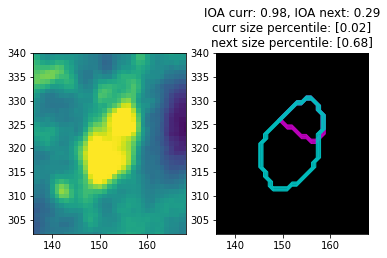

In [213]:
ind_i = 0
fig, ax = plt.subplots(1, 2)
ax[0].imshow(img)
draw_mask_overlaps(ax[1], masks[mat_i], masks[mat_i+1], temp_curr_ind[ind_i], temp_new_ind[ind_i])
ax[0].set_xlim(ax[1].get_xlim())
ax[0].set_ylim(ax[1].get_ylim())

In [76]:
mask1 = masks[0]
mask2 = masks[1]
roi_inds1 = np.setdiff1d(np.unique(mask1), [0])
roi_inds2 = np.setdiff1d(np.unique(mask2), [0])
overlap_mat = np.zeros((len(roi_inds1), len(roi_inds2)))
visited_roi_inds2 = []
for j in range(len(roi_inds1)):
    temp_roi_ind1_map = mask1 == roi_inds1[j]
    temp_roi_ind2_visit = np.setdiff1d(np.unique(mask2[temp_roi_ind1_map]), [0])
    visited_roi_inds2.extend(temp_roi_ind2_visit)
    for temp_roi_2 in temp_roi_ind2_visit:
        k = np.where(roi_inds2 == temp_roi_2)[0][0]
        intersection_map = temp_roi_ind1_map * (mask2 == temp_roi_2) > 0
        union_map = temp_roi_ind1_map + (mask2 == temp_roi_2) > 0
        overlap_mat[j, k] = np.sum(intersection_map) / np.sum(union_map)
left_roi_inds2 = np.setdiff1d(roi_inds2, np.unique(visited_roi_inds2))
for temp_roi_ind2 in left_roi_inds2:
    k = np.where(roi_inds2 == temp_roi_2)[0][0]
    temp_roi_ind2_map = mask2 == temp_roi_ind2
    temp_roi_ind1_visit = np.setdiff1d(np.unique(mask1[temp_roi_ind2_map]), [0])
    for temp_roi_ind1 in temp_roi_ind1_visit:
        j = np.where(roi_inds1 == temp_roi_ind1)[0][0]
        intersection_map = temp_roi_ind2_map * (mask1 == temp_roi_ind1) > 0
        union_map = temp_roi_ind2_map + (mask1 == temp_roi_ind1) > 0
        overlap_mat[j, k] = np.sum(intersection_map) / np.sum(union_map)